#Project: HummingFace | Data

Léo Dupire & Mateus Aragão

##Dataset: NSynth

###Data Characteristics

https://magenta.tensorflow.org/datasets/nsynth#note-qualities

####Dataset Features

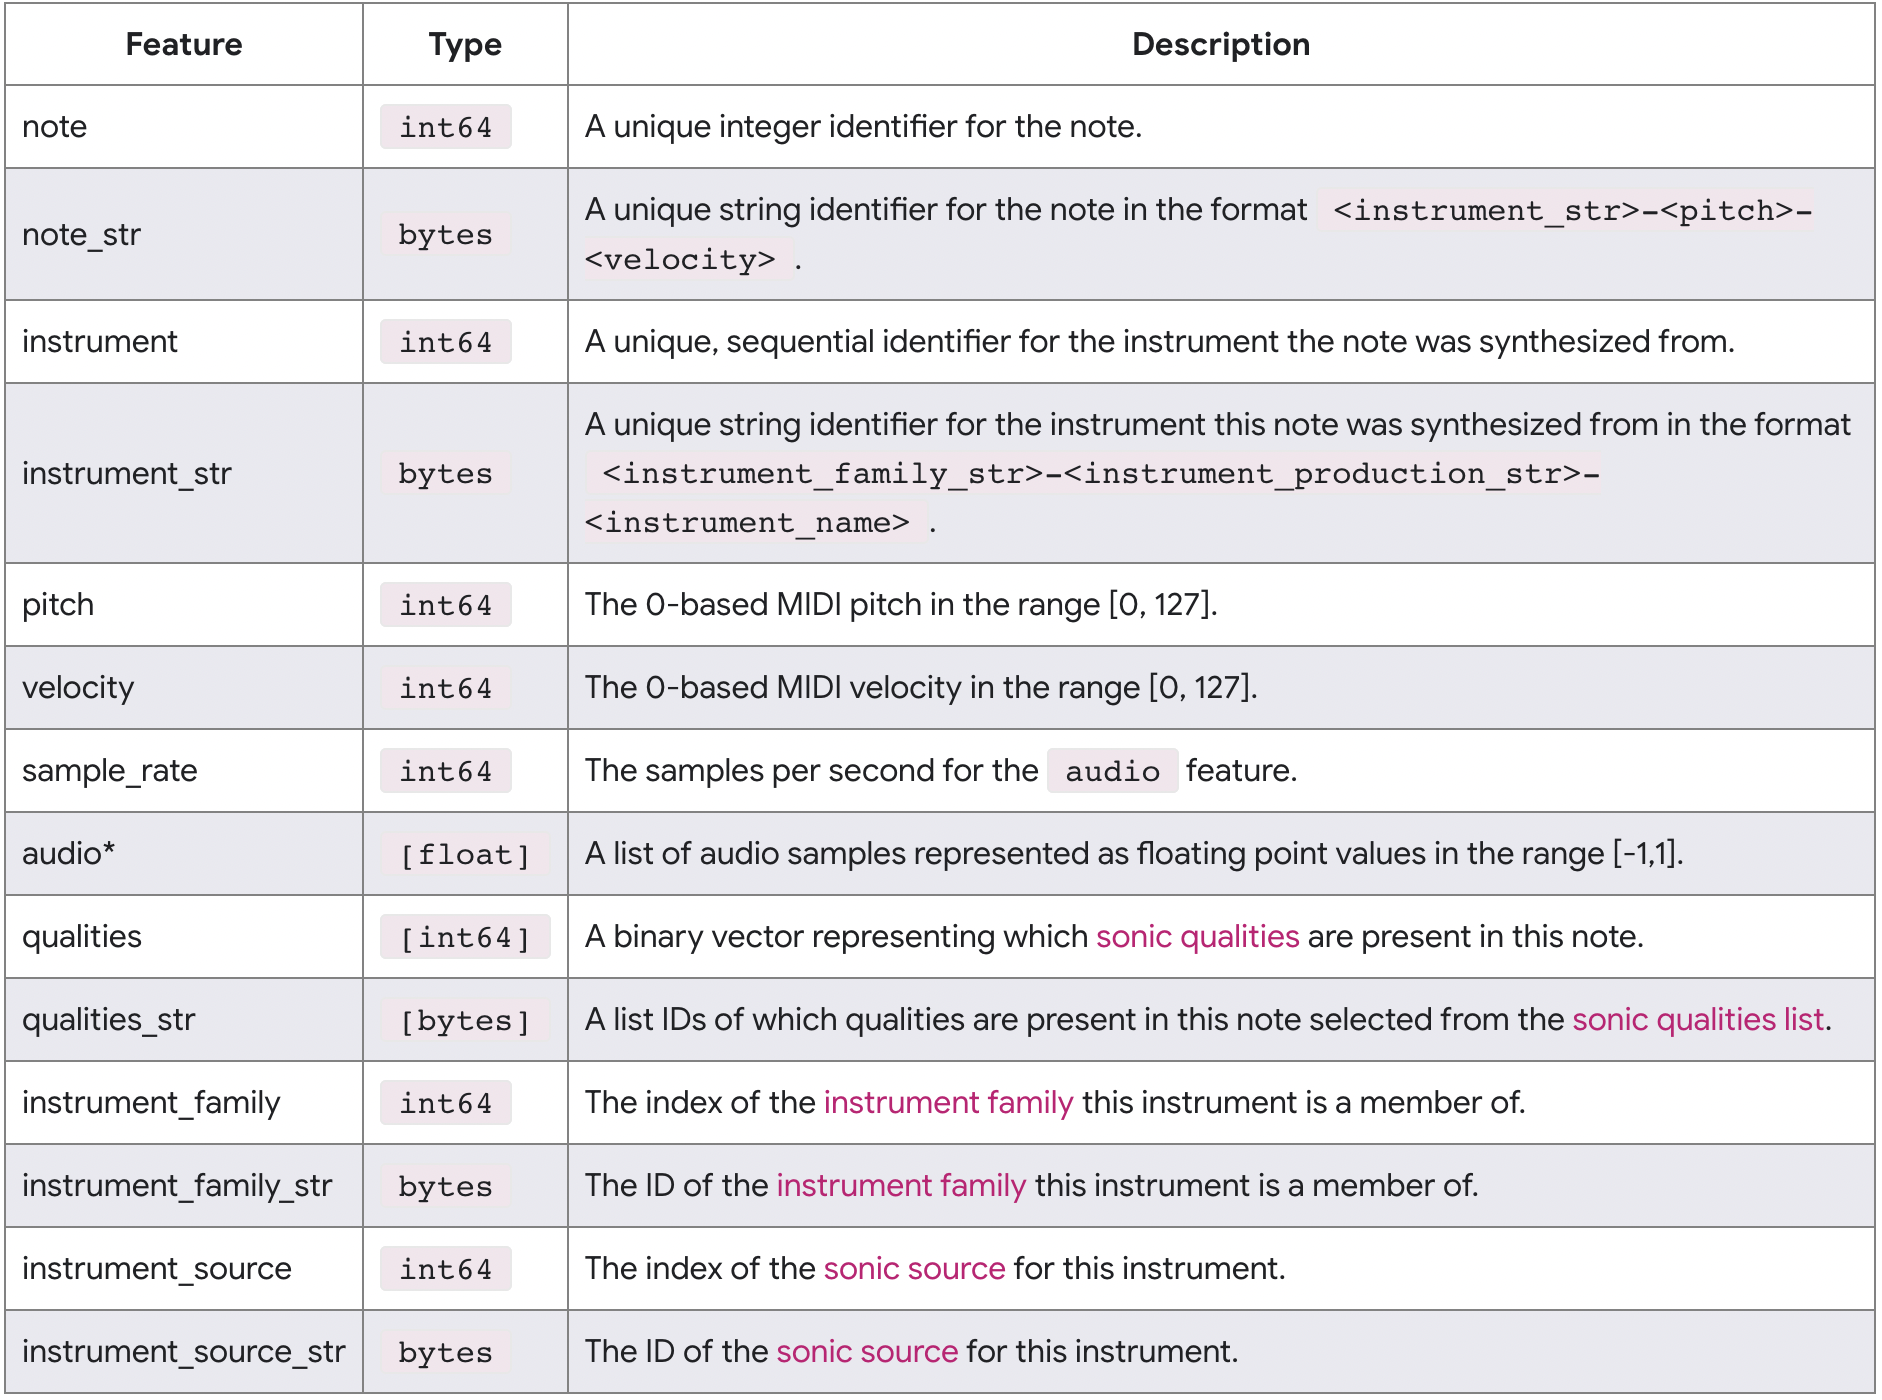

####Qualities Feature Descriptions

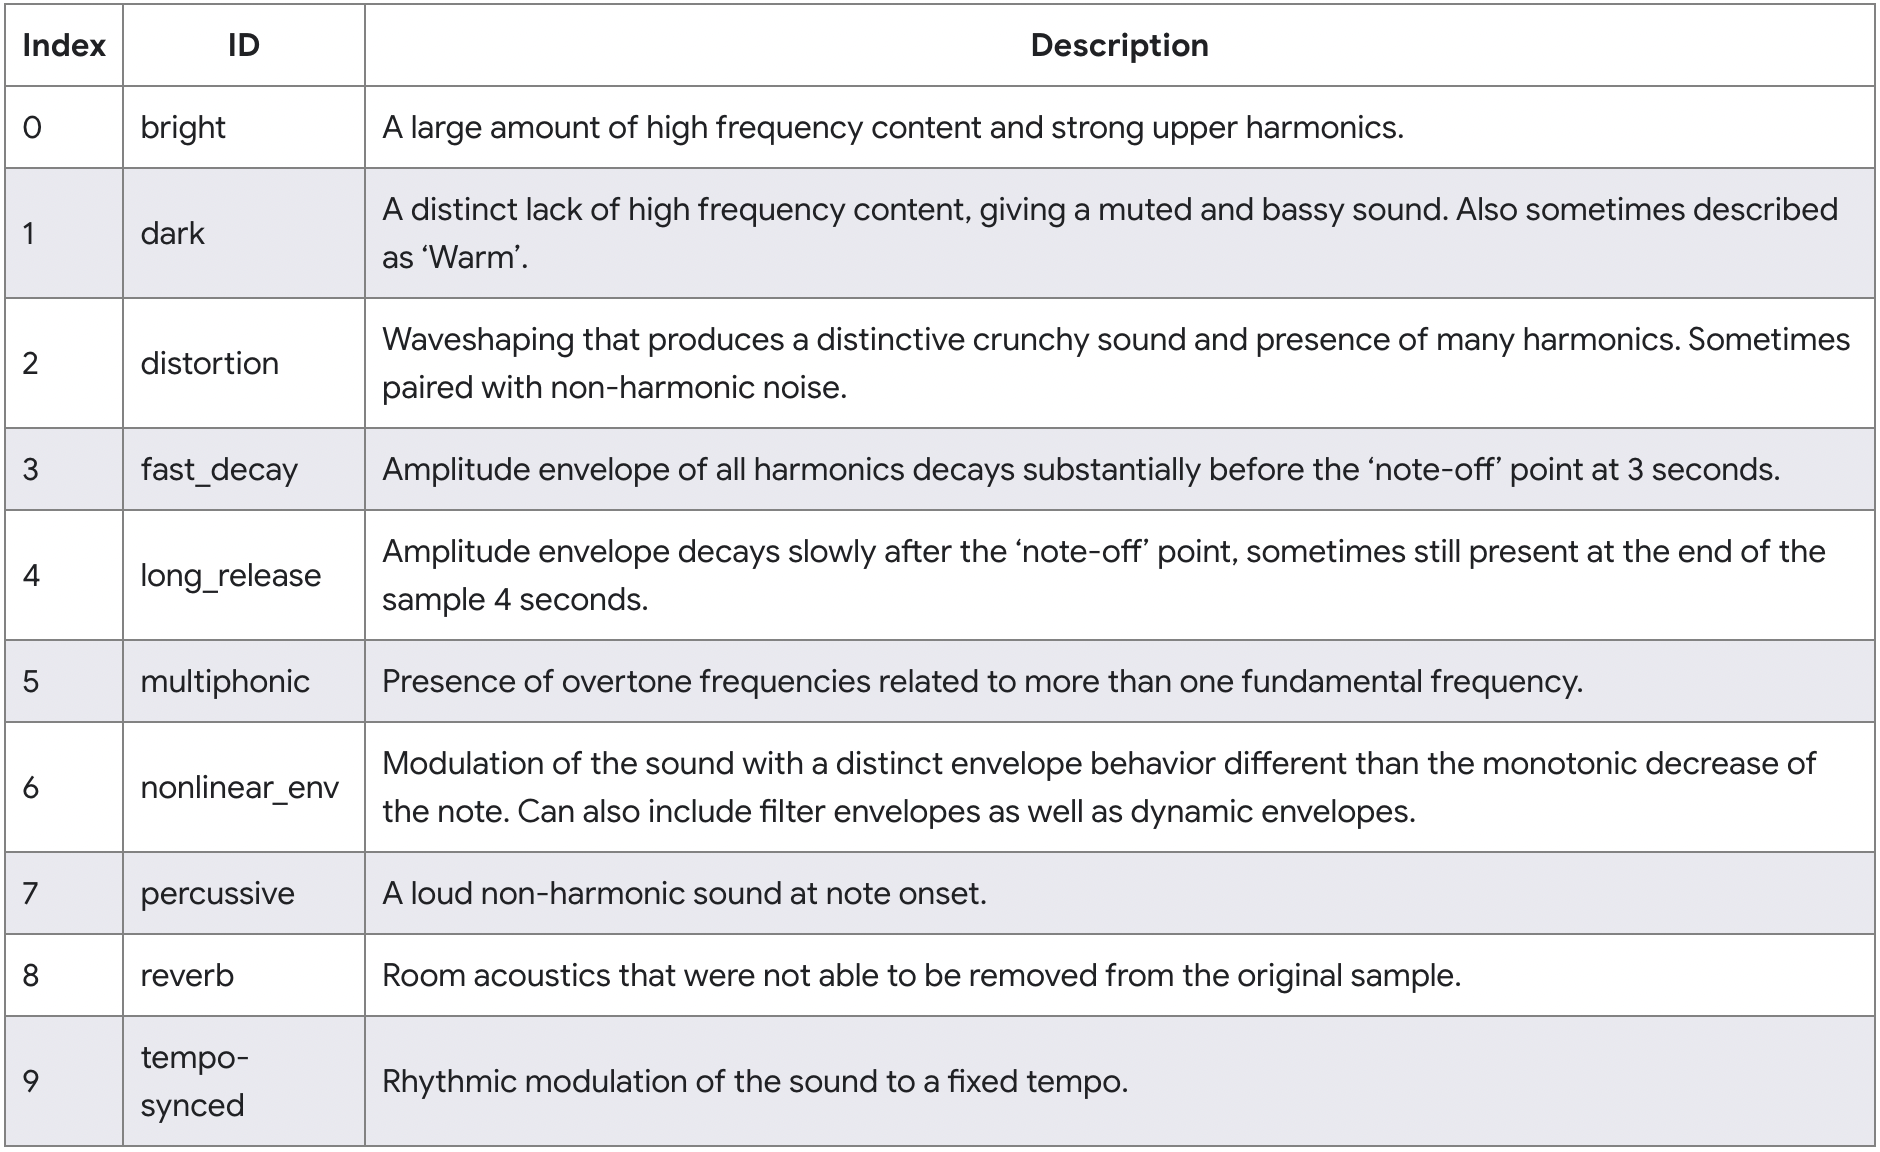

##Import Data

In [ ]:
%cd ./Desktop/HummingFace

/Users/leodupire/Desktop/HummingFace


In [1]:
%%script false --no-raise-error
# Import data - must change this to TRAIN/TEST below
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
!tar -xzvf "./nsynth-test.jsonwav.tar.gz"

##Pre-process Data

In [ ]:
#@title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from pydub import AudioSegment
from IPython.display import Audio, display

###Load Dataframe

In [ ]:
SET = "test"

df = pd.read_json(f"./nsynth-{SET}/examples.json", orient='index')
df.head(5)

In [ ]:
data = df.drop(columns=["note", "instrument_str", "instrument", "note_str", "sample_rate", "instrument_family_str"])
data.head()

Assign individual column to each of the quality features.

In [ ]:
qualities_data = pd.DataFrame(data.qualities.tolist(), index=data.index, columns=['bright','dark','distortion','fast_decay','long_release','multiphonic','nonlinear_env','percussive','reverb','tempo-synced'])
X = pd.concat([data, qualities_data], axis=1).drop(columns=["instrument_source_str", "qualities", "qualities_str"])
X = X.loc[(X.percussive != 1) & (X.pitch == 60)].drop(columns=["percussive"])
X

###Spectrogram Functions (explore MFCCs)

In [ ]:
# Convert raw audio into spectrogram
def spectrogramify(instance, phase, nperseg=1000):
  # instance: record name
  # phase: train, val, or test
  dir = "./nsynth-" + str(phase) + "/audio/" + str(instance) + ".wav"
  sample_rate, samples = wavfile.read(dir)
  frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=nperseg)

  return sample_rate, frequencies, times, spectrogram


# Display spectrogram
def show_spectro(times, frequencies, spectrogram):
  f = plt.figure()
  f.set_figwidth(5)
  f.set_figheight(3)

  plt.pcolormesh(times, frequencies, np.abs(spectrogram))
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.ylim([0, 2000])
  plt.show()


# Generate .wav file from spectrogram
def spectro_to_wav(spectrogram, sample_rate = 16000):
  _, gen = signal.istft(spectrogram, sample_rate)
  wavfile.write("output.wav", sample_rate, gen.astype(np.int16))
  return True


# Display/play audio from .wav file
def spectro_to_audio(spectrogram, sample_rate = 16000):
  spectro_to_wav(spectrogram, sample_rate)
  wav = "output.wav"
  display(Audio(wav, autoplay=True))


# Convert imaginary-valued spectrogram into depth-2 matrix (depth #1: real, depth #2: imaginary)
def decompose_spect(y):
  y_real = []
  y_imag = []
  for i in range(len(y)):
    y_real.append(y[i].real)
    y_imag.append(y[i].imag)
  return np.array(y_real), np.array(y_imag)


# Convert depth-2 (real, imaginary) matrix back to depth-1 matrix with values = real + imaginary*i (i = sqrt(-1))
def recompose_spect(y_real, y_imag):
  y = 1j*y_imag
  y += y_real
  return np.array(y)

###Data Manipulations

Convert raw audio to square matrix/spectrogram: 128x128. The sounds remain essentially the same:

In [ ]:
sample_rate = 16000
times = np.linspace(0, 1, 128)
freqs = np.linspace(0, 2032, 128)

In [ ]:
dataset = {"instance": [], "spectrogram": []}
for instance in X.index:
  _, frequencies, times, spectrogram = spectrogramify(instance, SET)
  dataset["instance"].append(instance)
  dataset["spectrogram"].append(spectrogram[:128, :128])

Display some spectrograms:

In [ ]:
for row in [1,2,3,4,5]:
  show_spectro(times, freqs, dataset["spectrogram"][row])

Play sound clip:

In [ ]:
spectro_to_audio(dataset["spectrogram"][10])

###Save Data

Convert imaginary number to 2 arrays of real numbers (one corresponding to imaginary coefficient).

In [ ]:
dataset_real, dataset_imag = decompose_spect(dataset["spectrogram"])

# Save
np.save(f"./{SET}_real.npy", dataset_real)
np.save(f"./{SET}_imag.npy", dataset_imag)
X.to_csv(f"./{SET}_df.csv")